###1. 라이브러리 불러오기

In [1]:
import os
import shutil
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# Visualization
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


###2. 데이터셋 정의 - 비오염

In [3]:
# Data loading and transformations
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Use PyTorch's torchvision.transforms.ToTenesor() to convert the dataset to tensor format
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
add_set = CIFAR100(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Use PyTorch's DataLoader to divide the dataset into mini-batches and load the data
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3060222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clippin

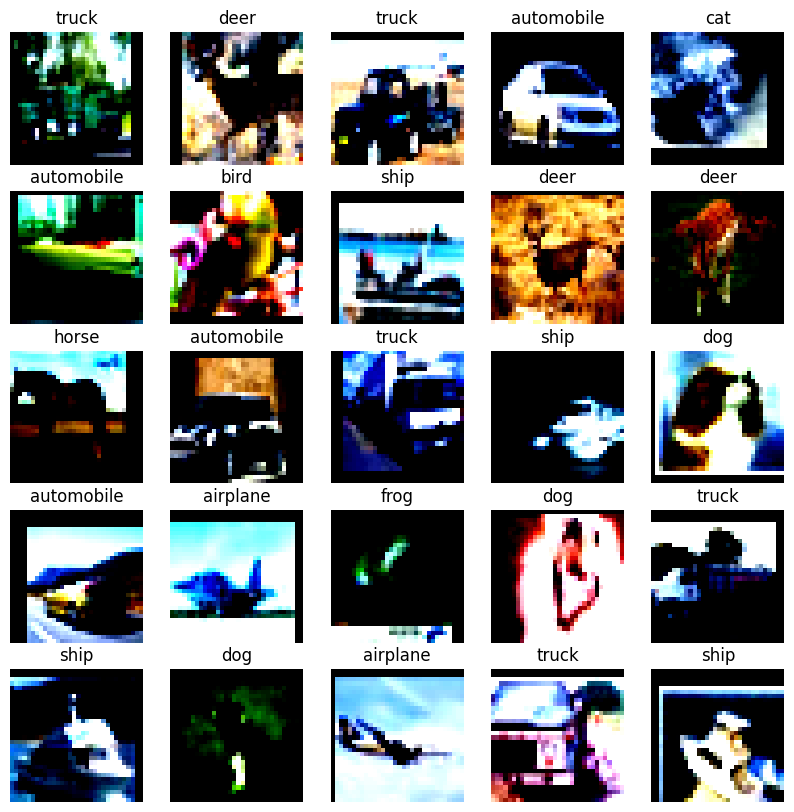

In [6]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

classes = train_set.classes

batch = next(iter(train_loader))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

###3. 신경망 코딩 - ResNet50

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [8]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

###4. 신경망 학습과 테스트 진행

In [9]:
# Evaluate function
def evaluate(model, device, test_loader):
  model.eval()
  total_correct = 0
  with torch.no_grad():
     for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, preds = torch.max(output, 1)
      total_correct += (preds == target).sum().item()

  accuracy = 100 * total_correct / len(test_loader.dataset)
  return accuracy

In [10]:
# Train and evaluate function
def train_and_evaluate(model, device, train_loader, test_loader, epochs=5):
  model.train()

  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

  accuracies = []

  for epoch in range(epochs):
    running_loss = 0.0
    data_iterator = iter(train_loader)
    for inputs, labels in data_iterator:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

    accuracy = evaluate(model, device, test_loader)
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy:.2f}%')

  return accuracies

In [23]:
acc_res = train_and_evaluate(model_res, device, train_loader, test_loader, epochs=5)

[Epoch 1] loss: 1.614
Accuracy: 52.59%
[Epoch 2] loss: 1.333
Accuracy: 56.92%
[Epoch 3] loss: 1.030
Accuracy: 63.21%
[Epoch 4] loss: 0.899
Accuracy: 69.58%
[Epoch 5] loss: 0.794
Accuracy: 73.11%


###데이터의 오염을 통한 학습 효율 변화

#데이터 오염 함수 정의
import random

# Label 오염을 10%의 샘플에 적용하는 함수 정의
def ood_label(dataset, pubutationset, attack_ratio=0.1):
    """
    CIFAR-10 데이터셋의 일부 샘플에 Label오염을 가하는 함수입니다.

    Args:
    - dataset: CIFAR-10 데이터셋 객체
    - attack_ratio: 공격할 이미지 비율 (0.1 = 10%)

    Returns:
    - attacked_dataset: 공격이 적용된 새로운 CIFAR-10 데이터셋 (TensorDataset)
    """
    # 전체 이미지와 라벨을 저장할 리스트
    attacked_images = []
    attacked_labels = []

    for idx in range(len(dataset)):
        # 이미지와 라벨을 가져오기
        image, label = dataset[idx]
        attacked_images.append(image)
        attacked_labels.append(label)

    # 전체 데이터셋의 attack_ratio 비율만큼 공격할 샘플 수 계산
    num_attack_samples = int(attack_ratio * len(dataset))
    total_attacked = 0
    idx = 0

    while total_attacked < num_attack_samples and idx <50000:
        # 원래 라벨을 제외한 랜덤으로 라벨 설정
        # 이미지와 라벨을 가져오기
        image, label = pubutationset[idx]
        while label >=0 and label < 10:
          idx += 1
          image, label = pubutationset[idx]

        # 리스트에 추가
        attacked_images.append(image)
        attacked_labels.append(label)
        total_attacked += 1
        idx += 1

    # 리스트를 텐서로 변환
    attacked_images_tensor = torch.stack(attacked_images)
    attacked_labels_tensor = torch.tensor(attacked_labels)

    # TensorDataset으로 묶어 새로운 데이터셋 반환
    attacked_dataset = TensorDataset(attacked_images_tensor, attacked_labels_tensor)
    return attacked_dataset

In [ ]:
def ood_label(dataset, perterbationset, attack_ratio=0.1):
    """
    CIFAR-10 데이터 셋의 클래스에만 CIFAR-100의 데이터 셋 오염을 섞는 함수

    Parameters:
    - cifar10_data (CIFAR10): 기존 CIFAR-10 데이터셋
    - cifar100_data (CIFAR100): CIFAR-100 데이터셋
    - target_class_num (int): CIFAR-100에서 추가할 클래스 번호
    - num_samples (int): 추가할 CIFAR-100 데이터 샘플 수 (default=100)

    Returns:
    - combined_dataset: CIFAR-10에 CIFAR-100에서 원하는 데이터를 추가한 데이터셋
    """
    # CIFAR-100에서 원하는 클래스를 필터링
    target_class_indices = [i for i, label in enumerate(perterbationset.targets)if label >=0 and label <10]

    # 원하는 숫자의 데이터를 선택 (기본적으로 10% 샘플)
    num_attack_samples = int(attack_ratio * len(dataset))
    selected_data = [perterbationset[i] for i in target_class_indices[:num_attack_samples]]

    # CIFAR-10과 CIFAR-100 데이터 합치기
    combined_data = dataset + selected_data

    return combined_data

In [13]:
train_set_op = ood_label(train_set, add_set, attack_ratio=0.1)

# DataLoader를 통해 배치 단위로 로드 가능
train_loader_op = DataLoader(dataset = train_set_op, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0996952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8858544

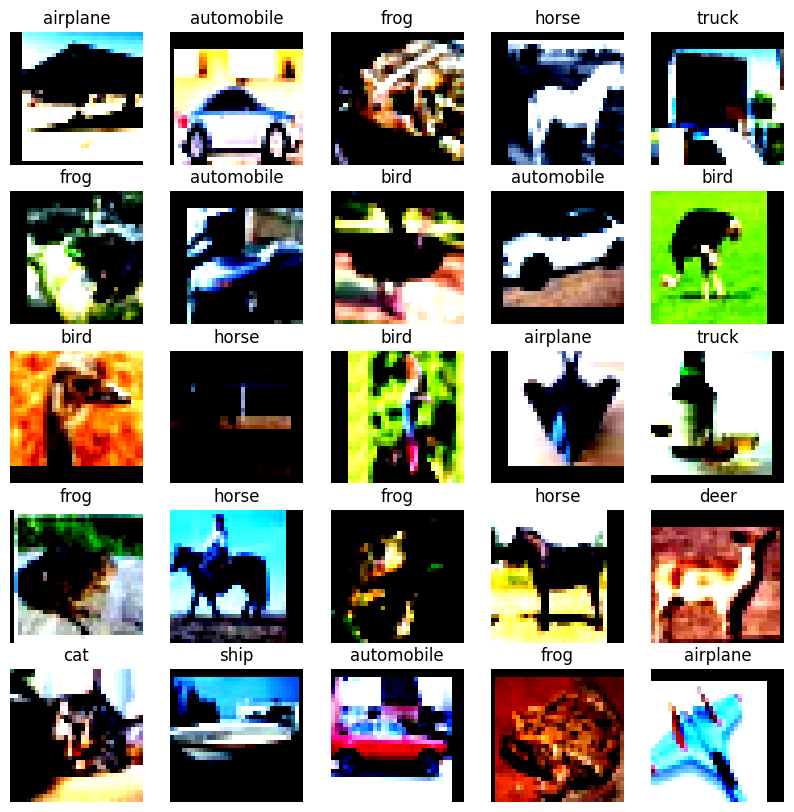

In [14]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

classes = test_set.classes

batch = next(iter(train_loader_op))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

In [15]:
#초기 신경망 생성 및 장치에 저장
model_res_c = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [16]:
acc_res_op = train_and_evaluate(model_res_c, device, train_loader_op, test_loader, epochs=5)

[Epoch 1] loss: 1.700
Accuracy: 54.05%
[Epoch 2] loss: 1.457
Accuracy: 60.05%
[Epoch 3] loss: 1.163
Accuracy: 64.44%
[Epoch 4] loss: 1.014
Accuracy: 68.76%
[Epoch 5] loss: 0.889
Accuracy: 72.50%


###오염된 양 증가

In [17]:
train_set_20 = ood_label(train_set, add_set, attack_ratio=0.2)
train_loader_20 = DataLoader(dataset = train_set_20, batch_size=64, shuffle=True)

train_set_40 = ood_label(train_set, add_set, attack_ratio=0.4)
train_loader_40 = DataLoader(dataset = train_set_40, batch_size=64, shuffle=True)

train_set_60 = ood_label(train_set, add_set, attack_ratio=0.6)
train_loader_60 = DataLoader(dataset = train_set_60, batch_size=64, shuffle=True)

In [18]:
#초기 신경망 생성 및 장치에 저장
model_res_20 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_res_40 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_res_60 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [19]:
acc_res_20 = train_and_evaluate(model_res_20, device, train_loader_20, test_loader, epochs=5)

[Epoch 1] loss: 1.706
Accuracy: 53.83%
[Epoch 2] loss: 1.402
Accuracy: 57.45%
[Epoch 3] loss: 1.136
Accuracy: 62.30%
[Epoch 4] loss: 0.997
Accuracy: 66.44%
[Epoch 5] loss: 0.874
Accuracy: 74.06%


In [20]:
acc_res_40 = train_and_evaluate(model_res_40, device, train_loader_40, test_loader, epochs=5)

[Epoch 1] loss: 1.669
Accuracy: 54.80%
[Epoch 2] loss: 1.365
Accuracy: 59.91%
[Epoch 3] loss: 1.105
Accuracy: 64.50%
[Epoch 4] loss: 0.970
Accuracy: 71.34%
[Epoch 5] loss: 0.847
Accuracy: 73.49%


In [21]:
acc_res_60 = train_and_evaluate(model_res_60, device, train_loader_60, test_loader, epochs=5)

[Epoch 1] loss: 1.706
Accuracy: 53.60%
[Epoch 2] loss: 1.383
Accuracy: 59.01%
[Epoch 3] loss: 1.130
Accuracy: 65.21%
[Epoch 4] loss: 0.996
Accuracy: 69.74%
[Epoch 5] loss: 0.887
Accuracy: 71.54%


###최종 비교 그래프

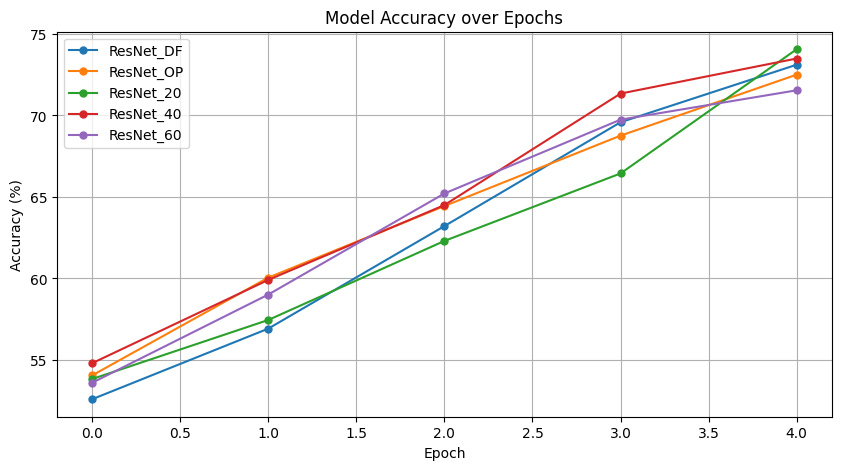

In [24]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_DF')
plt.plot(acc_res_op, marker='o', linestyle='-', markersize=5, label='ResNet_OP')
plt.plot(acc_res_20, marker='o', linestyle='-', markersize=5, label='ResNet_20')
plt.plot(acc_res_40, marker='o', linestyle='-', markersize=5, label='ResNet_40')
plt.plot(acc_res_60, marker='o', linestyle='-', markersize=5, label='ResNet_60')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

결론: ResNet50에 대한 공격 효용성이 매우 약함

In [25]:
# Random Label 알고리즘 검증용
train_set_all = ood_label(train_set, add_set, attack_ratio=1)
train_loader_all = DataLoader(dataset = train_set_all, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.169412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6116778].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2042704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.186841].

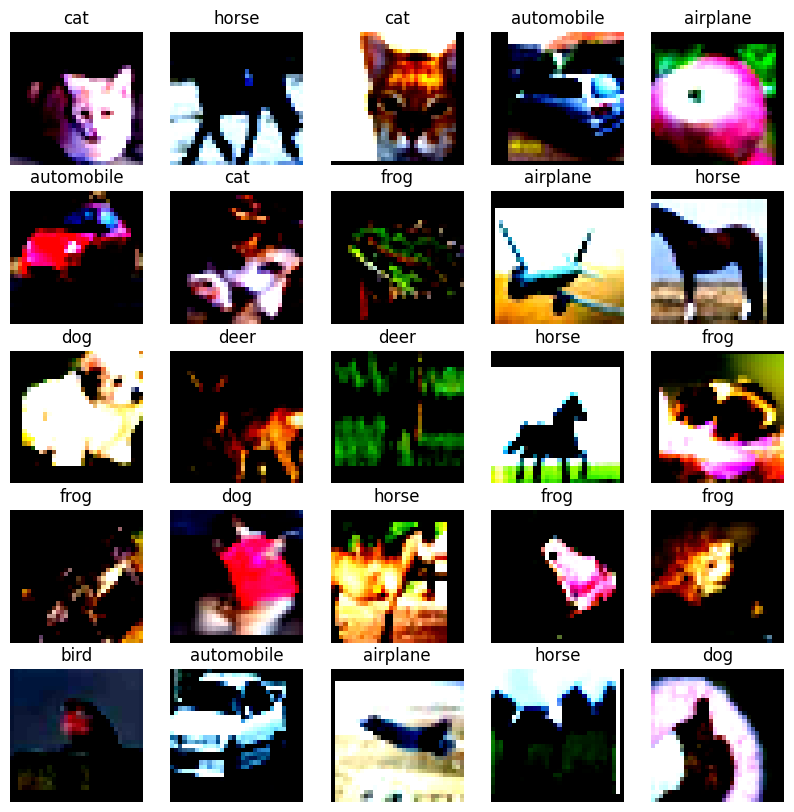

In [26]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

classes = test_set.classes

batch = next(iter(train_loader_all))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()